In [109]:
# ============================
# 🧩 Librerías principales
# ============================
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# 🧪 Modelado y Preprocesamiento
# ============================
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_halving_search_cv  


# ============================
# 🤖 Modelos de ML
# ============================
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier

# ============================
# 📏 Métricas
# ============================
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# ============================
# 🔍 Optimización
# ============================
import optuna
from optuna.integration import OptunaSearchCV
from optuna.exceptions import TrialPruned

# ============================
# 🧬 Algoritmos genéticos
# ============================
import pygad


from imblearn.over_sampling import SMOTE



In [110]:
# =====================
# 1) Cargar dataset
# =====================
df = pd.read_csv("Telco-Customer-Churn.csv")

print("Length of the data set:", len(df))
print("Number of characteristics of the data set:", len(df.columns))

# =====================
# 2) Convertir TotalCharges a numérico
# =====================
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Verificar
print(df['TotalCharges'].dtype)
print("NaN en TotalCharges:", df['TotalCharges'].isna().sum())


Length of the data set: 7043
Number of characteristics of the data set: 21
float64
NaN en TotalCharges: 11


In [111]:
# Construction of a function that performs the complete partitioning
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [112]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    # Para Telco Churn convertimos "Yes"/"No" a 1/0
    if label_name == "Churn":
        y = y.map({"No": 0, "Yes": 1})
    return X, y

In [113]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class CustomPreImputer(BaseEstimator, TransformerMixin):
    """
    - Imputa TODAS las columnas categóricas (dtype 'object') con la moda.
    - Para columnas categóricas con EXACTAMENTE 2 valores distintos,
      las convierte a 0 y 1.
    - El resto de categóricas se dejan como texto para OneHotEncoder.
    """

    def __init__(self):
        self.cat_modes_ = {}       # moda de cada columna categórica
        self.binary_mappings_ = {} # dict: col -> {categoria: 0/1}

    def fit(self, X, y=None):
        X_df = X.copy()

        # 1) Identificar columnas categóricas
        cat_cols = X_df.select_dtypes(include=["object"]).columns

        for col in cat_cols:
            # Moda
            mode_col = X_df[col].dropna().mode()
            if len(mode_col) > 0:
                self.cat_modes_[col] = mode_col.iloc[0]

            # Serie imputada temporalmente para contar categorías
            temp = X_df[col].fillna(self.cat_modes_[col]) if col in self.cat_modes_ else X_df[col]
            uniques = list(pd.Series(temp).unique())

            # 2) Si la columna tiene EXACTAMENTE 2 categorías, la marcamos como binaria
            if len(uniques) == 2:
                # Caso especial: Yes/No → fijamos explícitamente 0/1
                if set(uniques) == {"Yes", "No"}:
                    mapping = {"No": 0, "Yes": 1}
                else:
                    # cualquier otro binario (Male/Female, etc.)
                    # primera categoría → 0, segunda → 1
                    mapping = {uniques[0]: 0, uniques[1]: 1}
                self.binary_mappings_[col] = mapping

        return self

    def transform(self, X, y=None):
        X_df = X.copy()

        # 1) Imputar categóricas con su moda
        for col, mode_val in self.cat_modes_.items():
            if col in X_df.columns:
                X_df[col] = X_df[col].fillna(mode_val)

        # 2) Mapear columnas binarias a 0/1
        for col, mapping in self.binary_mappings_.items():
            if col in X_df.columns:
                X_df[col] = X_df[col].map(mapping).astype("Int64")

        return X_df


In [114]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        try:
            self._oh = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        except TypeError:
            self._oh = OneHotEncoder(sparse=False, handle_unknown="ignore")
        self._columns = []

    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object']).copy()
        if X_cat.shape[1] == 0:
            self._columns = []
            self._oh.fit(pd.DataFrame(index=X.index))
            return self
        self._oh.fit(X_cat)
        self._columns = self._oh.get_feature_names_out(X_cat.columns)
        return self

    def transform(self, X, y=None):
        X_cat = X.select_dtypes(include=['object']).copy()
        if X_cat.shape[1] == 0:
            return pd.DataFrame(index=X.index)
        X_cat_oh = self._oh.transform(X_cat)
        return pd.DataFrame(X_cat_oh, columns=self._columns, index=X.index)


In [115]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])


In [116]:
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._pre_imputer = CustomPreImputer()   # para categóricas
        self._full_pipeline = None
        self._columns = None
        self.input_features_ = None

    def fit(self, X, y=None):
        # 0) Pre-imputación global
        X1 = self._pre_imputer.fit_transform(X)
        self.input_features_ = list(X1.columns)

        # 1) Detectar numéricas y categóricas DESPUÉS de la pre-imputación
        num_attribs = list(X1.select_dtypes(exclude=['object']).columns)
        cat_attribs = list(X1.select_dtypes(include=['object']).columns)

        # 2) ColumnTransformer con num_pipeline y OneHot
        self._full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X1)

        # 3) Guardar nombres de columnas de salida
        out_cols = []
        out_cols.extend(num_attribs)
        cat_encoder = self._full_pipeline.named_transformers_["cat"]
        if hasattr(cat_encoder, "_columns") and len(cat_encoder._columns) > 0:
            out_cols.extend(list(cat_encoder._columns))
        self._columns = out_cols
        return self

    def transform(self, X, y=None):
        X1 = self._pre_imputer.transform(X)
        X_prep = self._full_pipeline.transform(X1)
        return pd.DataFrame(X_prep, columns=self._columns, index=X.index)


In [117]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


## 1.Dataset Selection (Optional):

In [118]:
df.drop(columns=['customerID'], inplace=True)


## 2. Exploratory Data Analysis (EDA):

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [120]:
df.nunique()


gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64

In [121]:
for col in df.select_dtypes(include='object').columns:
    print(f"\n===== {col} =====")
    print(df[col].unique())



===== gender =====
['Female' 'Male']

===== Partner =====
['Yes' 'No']

===== Dependents =====
['No' 'Yes']

===== PhoneService =====
['No' 'Yes']

===== MultipleLines =====
['No phone service' 'No' 'Yes']

===== InternetService =====
['DSL' 'Fiber optic' 'No']

===== OnlineSecurity =====
['No' 'Yes' 'No internet service']

===== OnlineBackup =====
['Yes' 'No' 'No internet service']

===== DeviceProtection =====
['No' 'Yes' 'No internet service']

===== TechSupport =====
['No' 'Yes' 'No internet service']

===== StreamingTV =====
['No' 'Yes' 'No internet service']

===== StreamingMovies =====
['No' 'Yes' 'No internet service']

===== Contract =====
['Month-to-month' 'One year' 'Two year']

===== PaperlessBilling =====
['Yes' 'No']

===== PaymentMethod =====
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

===== Churn =====
['No' 'Yes']


In [122]:
df.describe()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [123]:
for col in df.columns:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())



--- gender ---
gender
Male      3555
Female    3488
Name: count, dtype: int64

--- SeniorCitizen ---
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

--- Partner ---
Partner
No     3641
Yes    3402
Name: count, dtype: int64

--- Dependents ---
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

--- tenure ---
tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64

--- PhoneService ---
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

--- MultipleLines ---
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

--- InternetService ---
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

--- OnlineSecurity ---
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

--- OnlineB

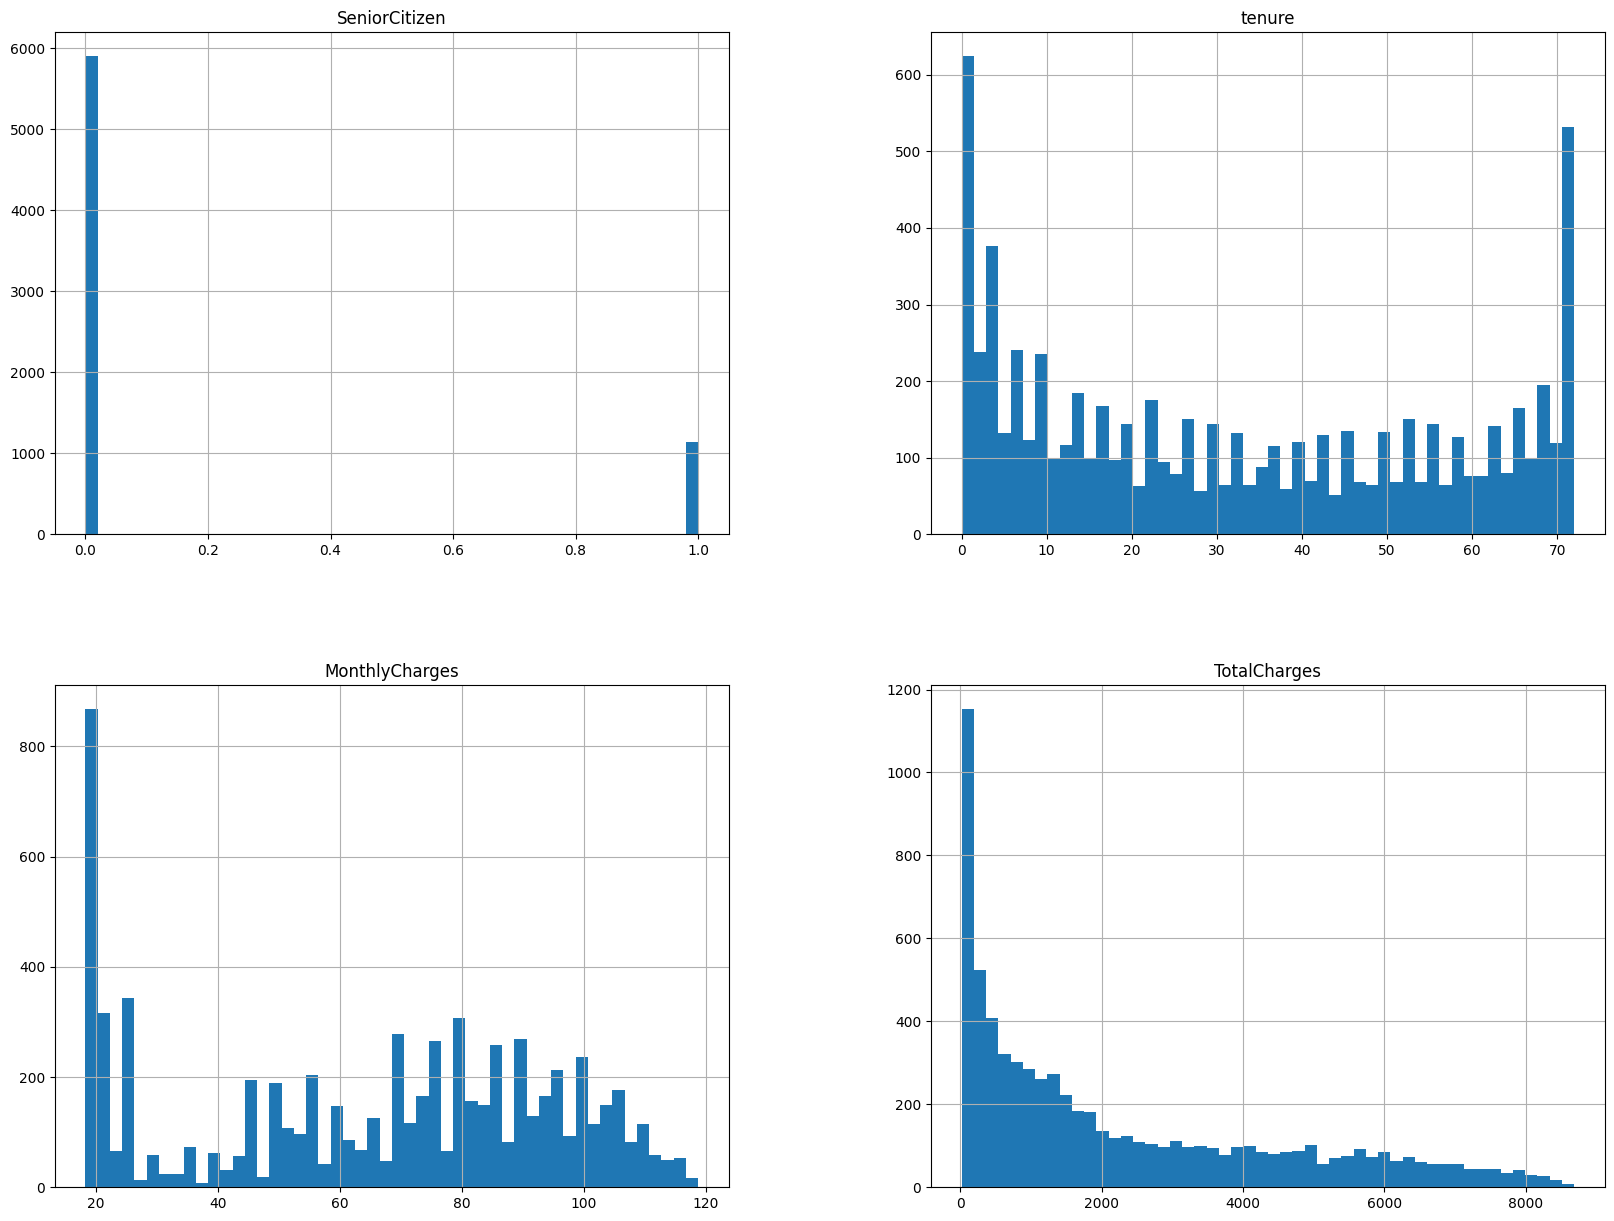

In [124]:
# Graph the distribution of attributes
df.hist(bins=50, figsize=(20,15))
plt.show()

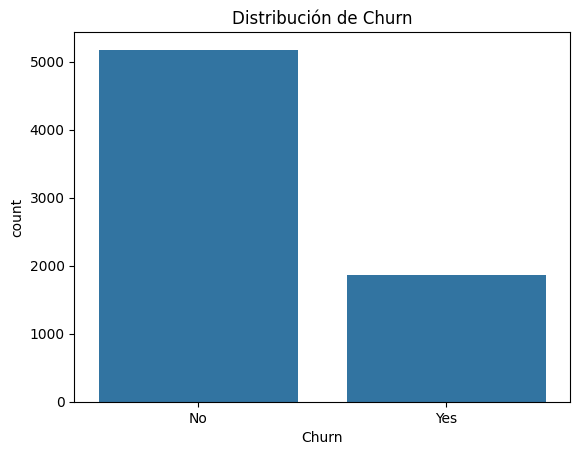

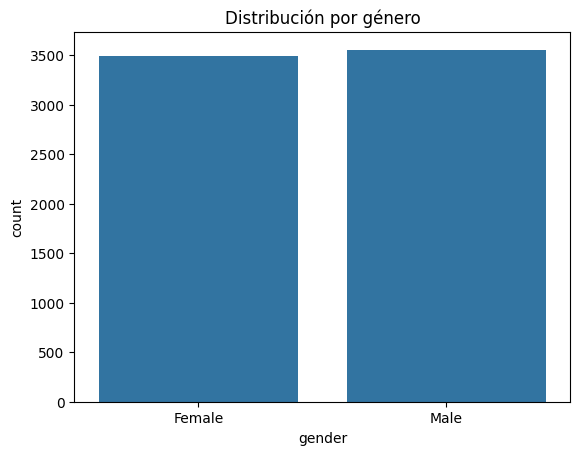

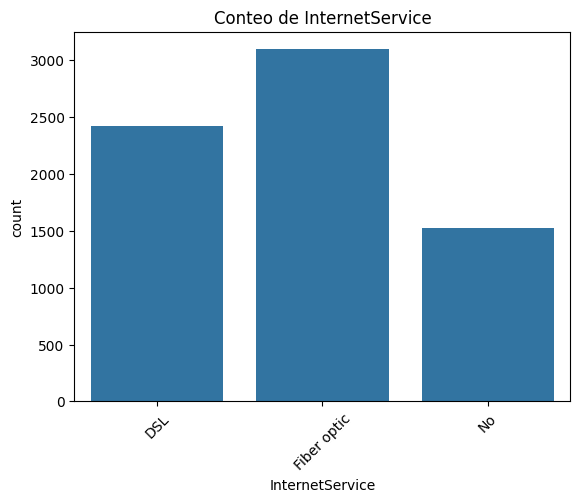

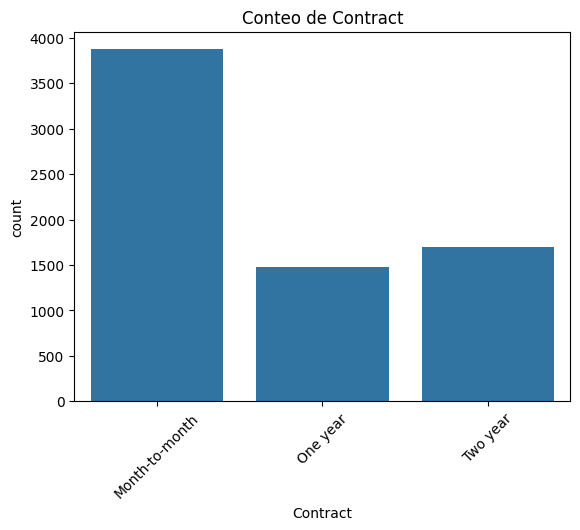

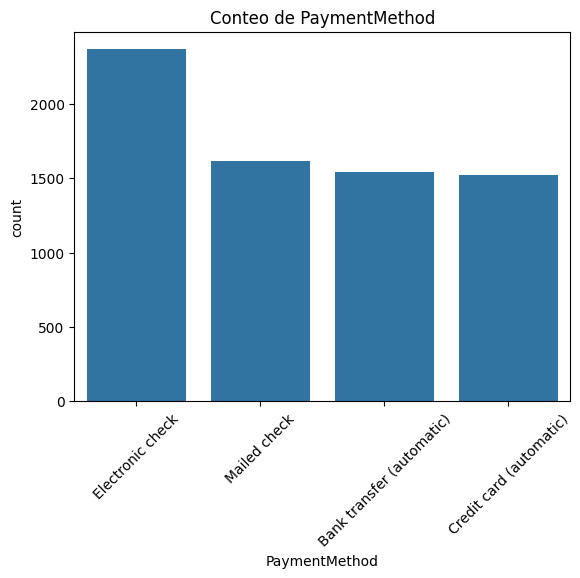

In [125]:
# Distribución de la variable objetivo
sns.countplot(x="Churn", data=df)
plt.title("Distribución de Churn")
plt.show()

# Otro ejemplo: género
sns.countplot(x="gender", data=df)
plt.title("Distribución por género")
plt.show()

# Si quieres hacer un loop por varias categóricas:
for col in ["InternetService", "Contract", "PaymentMethod"]:
    plt.figure()
    sns.countplot(x=col, data=df)
    plt.title(f"Conteo de {col}")
    plt.xticks(rotation=45)
    plt.show()


In [126]:
# We split the dataset
train_set, val_set, test_set = train_val_test_split(df, stratify='Churn')

In [127]:
print("Length of the Training Set:", len(train_set))
print("Length of the Validation Set:", len(val_set))
print("Length of Test Set:", len(test_set))

Length of the Training Set: 4225
Length of the Validation Set: 1409
Length of Test Set: 1409


In [128]:
X_train, y_train = remove_labels(train_set, 'Churn')
X_val, y_val = remove_labels(val_set, 'Churn')
X_test, y_test = remove_labels(test_set, 'Churn')

In [129]:
prep = DataFramePreparer()
prep.fit(X_train)

DataFramePreparer()

In [130]:
X_train_prep = prep.transform(X_train)
X_val_prep = prep.transform(X_val)
X_test_prep = prep.transform(X_test)

In [131]:
X_train_prep.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2833,-1.0,0.0,0.0,0.0,0.804348,0.0,0.0,-0.171846,0.764122,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
846,-1.0,0.0,0.0,0.0,0.782609,0.0,0.0,0.261426,1.180819,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2501,0.0,0.0,1.0,1.0,0.934783,0.0,-1.0,-0.917733,-0.005556,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6729,0.0,0.0,1.0,1.0,0.847826,0.0,0.0,0.043876,1.034589,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2903,0.0,0.0,1.0,1.0,-0.369565,-1.0,-1.0,-0.640768,-0.272078,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [132]:
X_train_prep.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 2833 to 191
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   4225 non-null   float64
 1   SeniorCitizen                            4225 non-null   float64
 2   Partner                                  4225 non-null   float64
 3   Dependents                               4225 non-null   float64
 4   tenure                                   4225 non-null   float64
 5   PhoneService                             4225 non-null   float64
 6   PaperlessBilling                         4225 non-null   float64
 7   MonthlyCharges                           4225 non-null   float64
 8   TotalCharges                             4225 non-null   float64
 9   MultipleLines_No                         4225 non-null   float64
 10  MultipleLines_No phone service           4225 non-n

In [133]:
for col in X_train_prep.columns:
    print(f"\n--- {col} ---")
    print(X_train_prep[col].value_counts())


--- gender ---
gender
 0.0    2125
-1.0    2100
Name: count, dtype: int64

--- SeniorCitizen ---
SeniorCitizen
0.0    3543
1.0     682
Name: count, dtype: int64

--- Partner ---
Partner
0.0    2190
1.0    2035
Name: count, dtype: int64

--- Dependents ---
Dependents
0.0    2965
1.0    1260
Name: count, dtype: int64

--- tenure ---
tenure
-0.608696    369
 0.934783    218
-0.586957    140
 0.913043    112
-0.543478    111
            ... 
 0.108696     33
 0.565217     33
-0.021739     30
 0.152174     29
-0.630435      7
Name: count, Length: 73, dtype: int64

--- PhoneService ---
PhoneService
 0.0    3811
-1.0     414
Name: count, dtype: int64

--- PaperlessBilling ---
PaperlessBilling
 0.0    2471
-1.0    1754
Name: count, dtype: int64

--- MonthlyCharges ---
MonthlyCharges
-0.923218    42
-0.921389    32
-0.925960    29
-0.930530    28
-0.917733    27
             ..
-0.668190     1
 0.419561     1
 0.127971     1
-0.489945     1
-0.265996     1
Name: count, Length: 1365, dtype: int

In [134]:
X_train_prep.shape

(4225, 40)

## 3. Ensemble Models:

In [135]:
def evaluar_modelo(nombre, modelo, X_train, y_train, X_eval, y_eval):
    t0 = time.time()
    modelo.fit(X_train, y_train)
    train_time = time.time() - t0

    y_pred = modelo.predict(X_eval)

    # Probabilidades para AUC
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_eval)[:, 1]
    elif hasattr(modelo, "decision_function"):
        from sklearn.preprocessing import MinMaxScaler
        scores = modelo.decision_function(X_eval)
        y_proba = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()
    else:
        # último recurso (ej. Voting Hard)
        y_proba = y_pred.astype(float)

    acc = accuracy_score(y_eval, y_pred)
    f1  = f1_score(y_eval, y_pred)
    auc = roc_auc_score(y_eval, y_proba)
    cm  = confusion_matrix(y_eval, y_pred)

    return {
        "Model": nombre,
        "Accuracy": acc,
        "F1": f1,
        "AUC": auc,
        "Train_Time_sec": train_time,
        "ConfusionMatrix": cm,
        "y_pred": y_pred
    }


In [136]:
# ============================
# Hiperparámetros comunes
# ============================

RF_PARAMS = dict(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

GB_PARAMS = dict(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

CAT_PARAMS = dict(
    iterations=300,          # mismo orden de magnitud que n_estimators
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    loss_function="Logloss",
    eval_metric="AUC",
    random_state=42,
    verbose=False
)

LR_PARAMS = dict(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

SVC_PARAMS = dict(
    C=1.0,
    kernel="rbf",
    gamma="scale",
    probability=True,
    random_state=42
)

# ============================
# 1. Bagging: Random Forest
# ============================

bagging_rf = RandomForestClassifier(**RF_PARAMS)

# ============================
# 2. Boosting: CatBoost
# ============================

boosting_cat = CatBoostClassifier(**CAT_PARAMS)

# ============================
# 3. Stacking: RF + GB + LR
# ============================

rf_base = RandomForestClassifier(**RF_PARAMS)

gb_base = GradientBoostingClassifier(**GB_PARAMS)

meta_lr = LogisticRegression(**LR_PARAMS)

stacking_model = StackingClassifier(
    estimators=[("rf", rf_base), ("gb", gb_base)],
    final_estimator=meta_lr,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# ============================
# 4. Voting: RF + SVC (hard / soft)
# ============================

rf_vote = RandomForestClassifier(**RF_PARAMS)

svc_vote = SVC(**SVC_PARAMS)

voting_hard = VotingClassifier(
    estimators=[("rf", rf_vote), ("svc", svc_vote)],
    voting="hard",
    n_jobs=-1
)



# ============================
# 5. Single Classifier: Logistic Regression
# ============================

single_lr = LogisticRegression(**LR_PARAMS)


In [137]:
X_eval, y_eval = X_val_prep, y_val   # o X_test_prep, y_test

results = []
cms = {}   # para guardar matrices de confusión
models = {
    "Bagging (RandomForest)": bagging_rf,
    "Boosting (CatBoost)": boosting_cat,
    "Stacking": stacking_model,


    "Single (LogReg)": single_lr
}

for name, model in models.items():
    print(f"Entrenando {name}...")
    res = evaluar_modelo(name, model, X_train_prep, y_train, X_eval, y_eval)
    cms[name] = res["ConfusionMatrix"]
    # quitamos ConfusionMatrix y y_pred del DataFrame final
    results.append({
        "Model": res["Model"],
        "Accuracy": res["Accuracy"],
        "F1": res["F1"],
        "AUC": res["AUC"],
        "Train_Time_sec": res["Train_Time_sec"]
    })

results_df = pd.DataFrame(results)
results_df


Entrenando Bagging (RandomForest)...
Entrenando Boosting (CatBoost)...
Entrenando Stacking...
Entrenando Single (LogReg)...


,Model,Accuracy,F1,AUC,Train_Time_sec
0,Bagging (RandomForest),0.792051,0.551302,0.833559,0.393152
1,Boosting (CatBoost),0.806955,0.591592,0.840494,0.962219
2,Stacking,0.802697,0.555911,0.844246,6.801068
3,Single (LogReg),0.824698,0.641509,0.859712,0.007105


## 4. Model Evaluation:

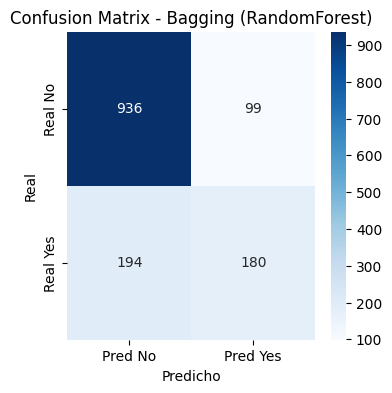

In [138]:
cm_lr = cms["Bagging (RandomForest)"]

plt.figure(figsize=(4,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred No", "Pred Yes"],
            yticklabels=["Real No", "Real Yes"])
plt.title("Confusion Matrix - Bagging (RandomForest)")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.show()


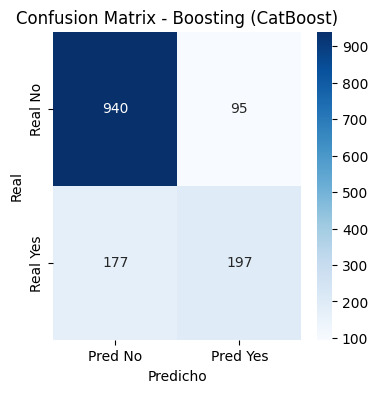

In [139]:
cm_lr = cms["Boosting (CatBoost)"]

plt.figure(figsize=(4,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred No", "Pred Yes"],
            yticklabels=["Real No", "Real Yes"])
plt.title("Confusion Matrix - Boosting (CatBoost)")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.show()


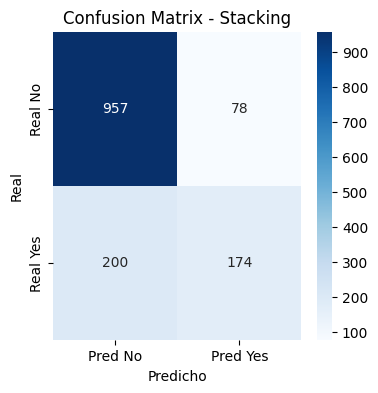

In [140]:
cm_lr = cms["Stacking"]

plt.figure(figsize=(4,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred No", "Pred Yes"],
            yticklabels=["Real No", "Real Yes"])
plt.title("Confusion Matrix - Stacking")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.show()

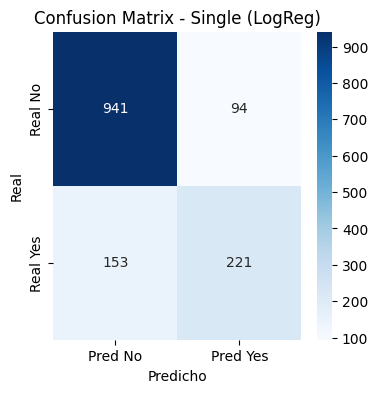

In [141]:
cm_lr = cms["Single (LogReg)"]

plt.figure(figsize=(4,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred No", "Pred Yes"],
            yticklabels=["Real No", "Real Yes"])
plt.title("Confusion Matrix - Single (LogReg)")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.show()

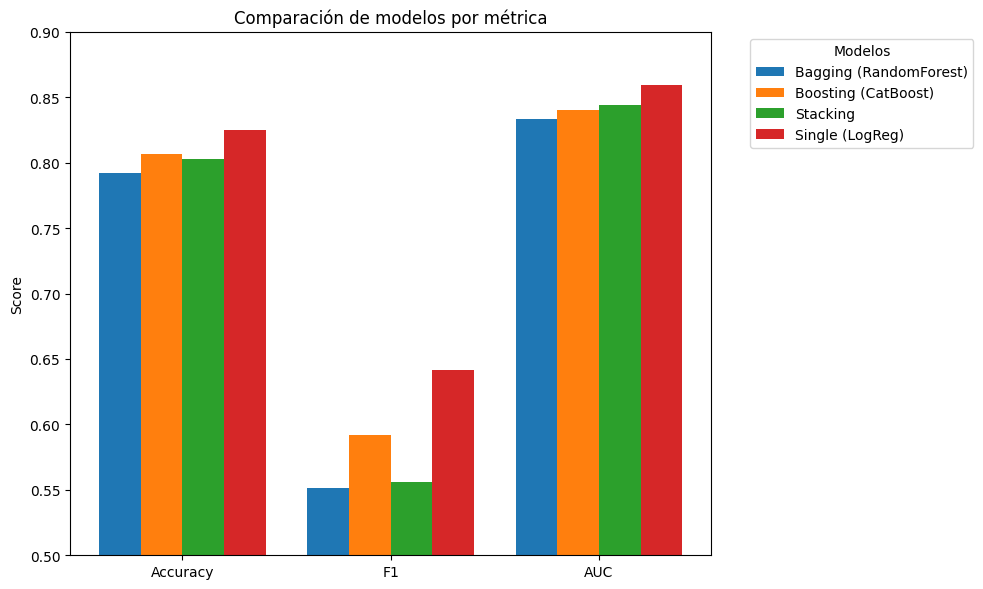

In [142]:
metrics = ["Accuracy", "F1", "AUC"]
x = np.arange(len(metrics))  # posiciones para las métricas

n_models = len(results_df)
width = 0.8 / n_models       # ancho de cada barra (para que todas quepan en cada grupo)

plt.figure(figsize=(10, 6))

for i, row in results_df.iterrows():
    # valores del modelo para cada métrica, en el mismo orden que 'metrics'
    scores = [row["Accuracy"], row["F1"], row["AUC"]]
    # desplazamos cada modelo un poquito a la derecha/izquierda
    offset = (i - n_models / 2) * width + width / 2
    plt.bar(x + offset, scores, width, label=row["Model"])

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0.5, 0.9)
plt.title("Comparación de modelos por métrica")
plt.legend(title="Modelos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Después de comparar varios métodos de aprendizaje supervisado —como Bagging (Random Forest), Boosting (CatBoost), Stacking, Voting Hard/Soft y un clasificador base— la Regresión Logística terminó siendo el modelo con mejor rendimiento general para predecir el churn en el dataset de Telco Customer Churn.

# Mejor desempeño en las métricas principales

La Regresión Logística obtuvo los valores más altos en las tres métricas más importantes:

Accuracy: fue el modelo que más predicciones correctas logró en total.

F1-Score: mostró el mejor balance entre precisión y recall, lo cual es clave porque la clase “Yes” (churn) es minoritaria.

AUC: también fue el modelo con mayor capacidad para distinguir entre clientes que van a hacer churn y los que no.

En resumen, la regresión logística no solo predice mejor, sino que lo hace de una manera más equilibrada y efectiva, especialmente cuando se trata de identificar correctamente a los clientes que podrían abandonar el servicio.

## 5. Class Balancing with SMOTE (Best Model Only):

In [143]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_prep, y_train)

print("Antes de SMOTE:", y_train.value_counts())
print("Después de SMOTE:", y_train_smote.value_counts())


Antes de SMOTE: Churn
0    3104
1    1121
Name: count, dtype: int64
Después de SMOTE: Churn
0    3104
1    3104
Name: count, dtype: int64


In [144]:
model_lr = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

model_lr.fit(X_train_prep, y_train)

y_pred_no = model_lr.predict(X_test_prep)
y_proba_no = model_lr.predict_proba(X_test_prep)[:, 1]

acc_no = accuracy_score(y_test, y_pred_no)
f1_no = f1_score(y_test, y_pred_no)
auc_no = roc_auc_score(y_test, y_proba_no)


In [145]:
model_lr_smote = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

model_lr_smote.fit(X_train_smote, y_train_smote)

y_pred_sm = model_lr_smote.predict(X_test_prep)
y_proba_sm = model_lr_smote.predict_proba(X_test_prep)[:, 1]

acc_sm = accuracy_score(y_test, y_pred_sm)
f1_sm = f1_score(y_test, y_pred_sm)
auc_sm = roc_auc_score(y_test, y_proba_sm)


In [146]:
comparison_df = pd.DataFrame({
    "Version": ["Sin SMOTE", "Con SMOTE"],
    "Accuracy": [acc_no, acc_sm],
    "F1-Score": [f1_no, f1_sm],
    "AUC": [auc_no, auc_sm]
})

comparison_df


,Version,Accuracy,F1-Score,AUC
0,Sin SMOTE,0.787083,0.565217,0.831946
1,Con SMOTE,0.742370,0.619098,0.830499


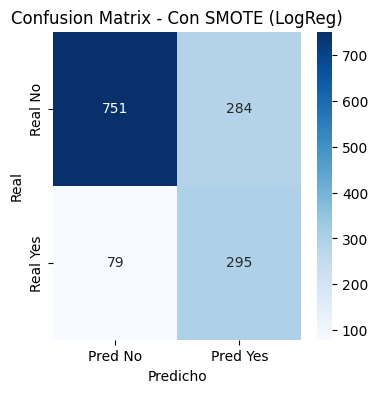

In [147]:
cm_sm = confusion_matrix(y_test, y_pred_sm)
plt.figure(figsize=(4,4))
sns.heatmap(cm_sm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred No", "Pred Yes"],
            yticklabels=["Real No", "Real Yes"])
plt.title("Confusion Matrix - Con SMOTE (LogReg)")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.show()

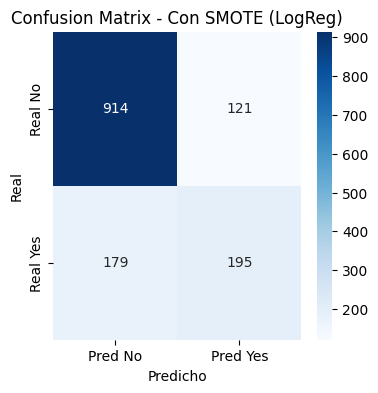

In [148]:
cm_no = confusion_matrix(y_test, y_pred_no)
plt.figure(figsize=(4,4))
sns.heatmap(cm_no, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred No", "Pred Yes"],
            yticklabels=["Real No", "Real Yes"])
plt.title("Confusion Matrix - Con SMOTE (LogReg)")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.show()

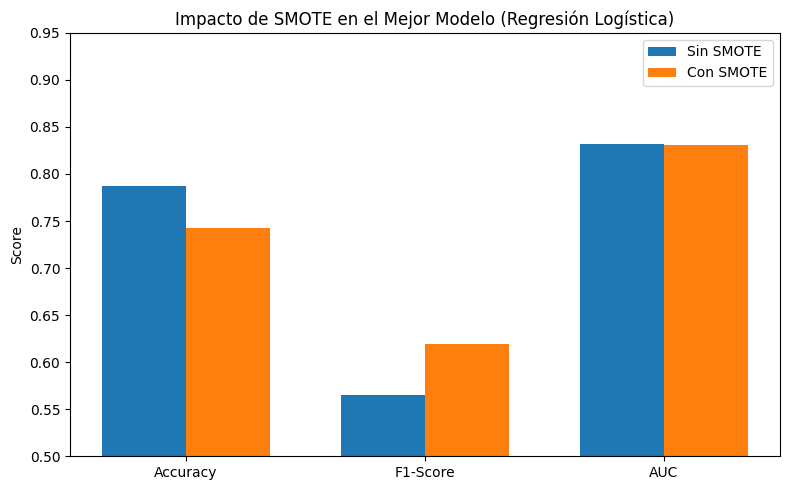

In [149]:
metrics = ["Accuracy", "F1-Score", "AUC"]
values_no = [acc_no, f1_no, auc_no]
values_sm = [acc_sm, f1_sm, auc_sm]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))

plt.bar(x - width/2, values_no, width, label="Sin SMOTE")
plt.bar(x + width/2, values_sm, width, label="Con SMOTE")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0.5, 0.95)
plt.title("Impacto de SMOTE en el Mejor Modelo (Regresión Logística)")
plt.legend()
plt.tight_layout()
plt.show()


Al aplicar SMOTE al conjunto de entrenamiento, el modelo de Regresión Logística logró una mejor capacidad para identificar correctamente a los clientes que harán churn. Esto se refleja en el incremento del F1-Score, que mejora al aumentar el recall sobre la clase minoritaria (“Yes”). 

Por otro lado, el Accuracy disminuye ligeramente debido al aumento de falsos positivos, lo cual es un efecto normal cuando se equilibra la distribución de clases. 

En cuanto al AUC, los resultados muestran que prácticamente no cambia entre el modelo con y sin SMOTE. Esto indica que la capacidad del modelo para ordenar correctamente los casos positivos y negativos se mantiene estable, incluso después del sobremuestreo sintético.

En general, SMOTE demostró ser beneficioso para este problema: mejoró la sensibilidad del modelo hacia la clase minoritaria sin sacrificar significativamente su capacidad discriminativa. Por ello, el modelo con SMOTE puede considerarse una mejor opción cuando el objetivo es maximizar la detección del churn

## 6. Feature Importance Analysis with the Best Model:

In [150]:
rf_smote = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_smote.fit(X_train_smote, y_train_smote)

importances_smote = rf_smote.feature_importances_
features_smote = X_train_smote.columns

df_imp_smote = pd.DataFrame({
    "Feature": features_smote,
    "Importance": importances_smote
}).sort_values(by="Importance", ascending=False)

df_imp_smote.head(15)


,Feature,Importance
8,TotalCharges,0.114509
4,tenure,0.114393
7,MonthlyCharges,0.105123
33,Contract_Month-to-month,0.094228
24,TechSupport_No,0.048047
15,OnlineSecurity_No,0.039920
38,PaymentMethod_Electronic check,0.035633
35,Contract_Two year,0.035104
6,PaperlessBilling,0.032233
0,gender,0.029324


C:\Users\jairo\AppData\Local\Temp\ipykernel_20528\101439438.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top, x="Importance", y="Feature", palette="viridis")


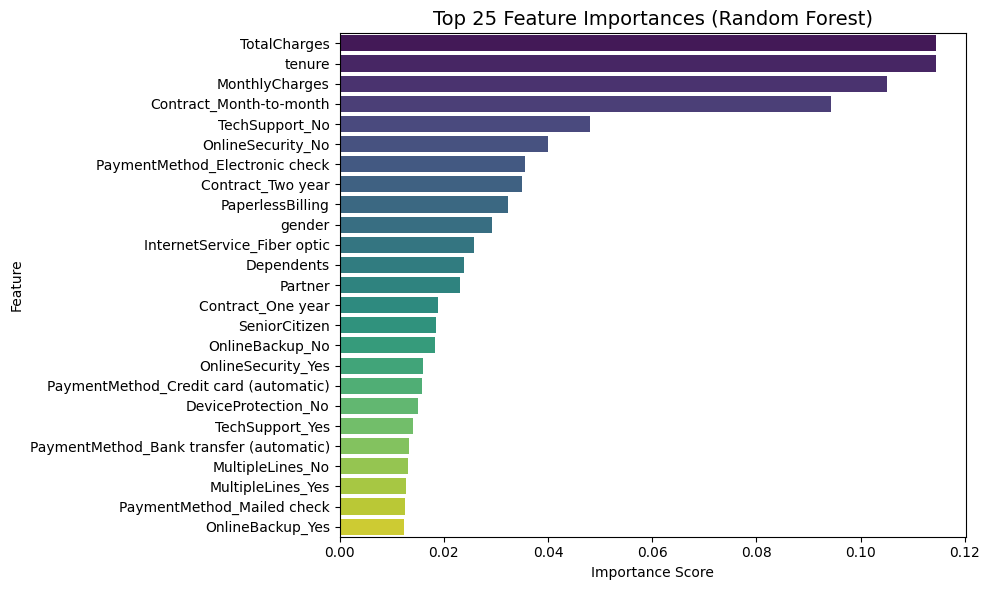

In [151]:
top_n = 25
df_top = df_imp_smote.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_top, x="Importance", y="Feature", palette="viridis")
plt.title("Top 25 Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Resumen de las variables principales

TotalCharges es la variable más importante; clientes con cargos totales bajos suelen ser nuevos y presentan mayor riesgo de churn.

tenure también es clave: usuarios con poca permanencia tienen alta probabilidad de abandonar.

MonthlyCharges influye significativamente; cargos mensuales altos pueden generar insatisfacción.

Contract_Month-to-month es uno de los mejores predictores: los contratos mensuales muestran el churn más elevado.

TechSupport_No indica que no contar con soporte técnico aumenta las probabilidades de abandonar.

PaymentMethod_Electronic check se asocia a mayor churn, posiblemente por problemas o incomodidades en el pago.

OnlineSecurity_No y OnlineBackup_No muestran que la falta de servicios adicionales incrementa la vulnerabilidad al churn.

PaperlessBilling también aparece como variable relevante en el comportamiento del cliente.

InternetService_Fiber optic contribuye al churn, probablemente por sus costos más altos.

Las variables demográficas como gender, Partner, SeniorCitizen o Dependents tienen un impacto menor comparado con factores económicos y contractuales.

In [152]:
resultados = []

for k in range(6, 20):  # de 6 a 15 features
    selected = df_imp_smote.head(k)["Feature"].tolist()

    X_train_k = X_train_smote[selected]
    X_test_k  = X_test_prep[selected]   # o X_val_prep si usas validación

    model = LogisticRegression(
        penalty="l2", C=1.0, solver="lbfgs",
        max_iter=1000, random_state=42
    )

    t0 = time.time()
    model.fit(X_train_k, y_train_smote)
    t_train = time.time() - t0

    y_pred = model.predict(X_test_k)
    y_prob = model.predict_proba(X_test_k)[:, 1]

    resultados.append([
        k,
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob),
        t_train
    ])

df_k_smote = pd.DataFrame(
    resultados,
    columns=["Features", "Accuracy", "F1", "AUC", "TrainTime"]
)

df_k_smote


,Features,Accuracy,F1,AUC,TrainTime
0,6,0.731015,0.603971,0.830428,0.008042
1,7,0.736693,0.613944,0.829883,0.007168
2,8,0.732434,0.615698,0.831586,0.006245
3,9,0.735273,0.616650,0.829054,0.000000
4,10,0.735273,0.615860,0.828766,0.007129
5,11,0.738822,0.619048,0.830158,0.005059
6,12,0.743080,0.621339,0.829055,0.003699
7,13,0.742370,0.621481,0.828913,0.005535
8,14,0.743080,0.622129,0.828867,0.010146
9,15,0.743080,0.622129,0.829182,0.004493


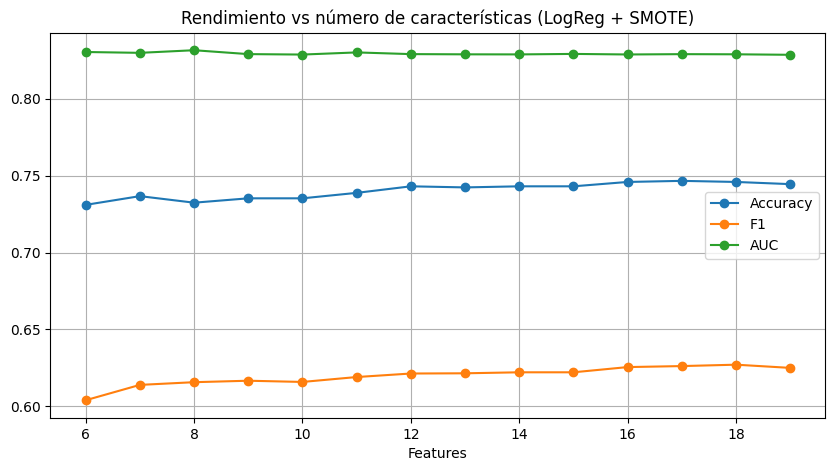

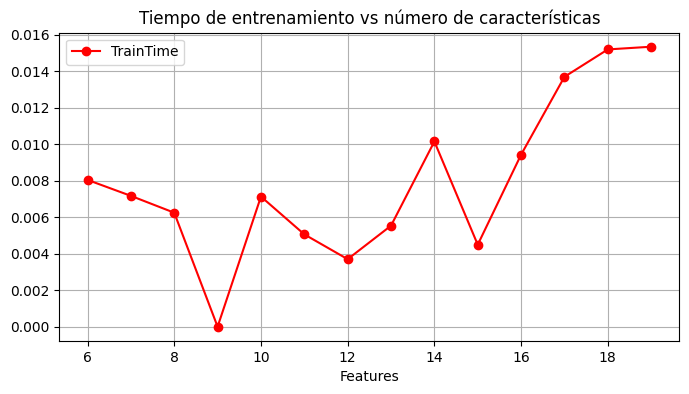

In [153]:
df_k_smote.plot(x="Features", y=["Accuracy", "F1", "AUC"],
                figsize=(10,5), marker="o")
plt.grid()
plt.title("Rendimiento vs número de características (LogReg + SMOTE)")
plt.show()

df_k_smote.plot(x="Features", y="TrainTime",
                figsize=(8,4), marker="o", color="red")
plt.grid()
plt.title("Tiempo de entrenamiento vs número de características")
plt.show()


Reentrenar con 12 caracteristicas

In [154]:
# 1) Sacamos las 12 variables más importantes (según RF con SMOTE)
top12 = df_imp_smote.head(12)["Feature"].tolist()

X_train_full = X_train_smote
X_test_full  = X_test_prep

X_train_top12 = X_train_smote[top12]
X_test_top12  = X_test_prep[top12]

# 2) Modelo mejor (Logistic Regression) – versión full
res_full = evaluar_modelo(
    "LogReg - Full (all features)",
    LogisticRegression(**LR_PARAMS),
    X_train_full,
    y_train_smote,
    X_test_full,
    y_test
)

# 3) Modelo mejor (Logistic Regression) – versión top 12
res_top12 = evaluar_modelo(
    "LogReg - Top 12 features",
    LogisticRegression(**LR_PARAMS),
    X_train_top12,
    y_train_smote,
    X_test_top12,
    y_test
)

# 4) Tabla comparativa
comparison = pd.DataFrame([
    {
        "Version": res_full["Model"],
        "Accuracy": res_full["Accuracy"],
        "F1": res_full["F1"],
        "AUC": res_full["AUC"],
        "TrainTime": res_full["Train_Time_sec"]
    },
    {
        "Version": res_top12["Model"],
        "Accuracy": res_top12["Accuracy"],
        "F1": res_top12["F1"],
        "AUC": res_top12["AUC"],
        "TrainTime": res_top12["Train_Time_sec"]
    }
])

comparison


,Version,Accuracy,F1,AUC,TrainTime
0,LogReg - Full (all features),0.74237,0.619098,0.830499,0.024403
1,LogReg - Top 12 features,0.74308,0.621339,0.829055,0.009583


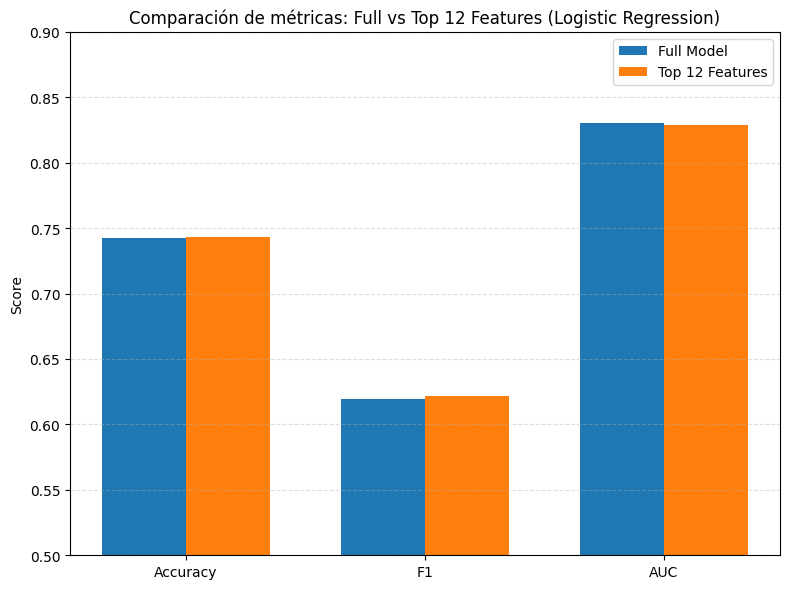

In [155]:
# Métricas a graficar
metrics = ["Accuracy", "F1", "AUC"]

# Valores
full_vals = [res_full[m] for m in metrics]
top12_vals = [res_top12[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35  # ancho de cada barra

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, full_vals, width, label="Full Model")
plt.bar(x + width/2, top12_vals, width, label="Top 12 Features")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Comparación de métricas: Full vs Top 12 Features (Logistic Regression)")
plt.ylim(0.5, 0.9)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


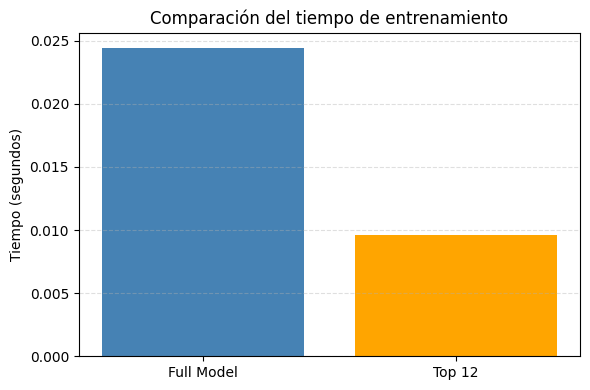

In [156]:
plt.figure(figsize=(6,4))
plt.bar(["Full Model", "Top 12"], 
        [res_full["Train_Time_sec"], res_top12["Train_Time_sec"]],
        color=["steelblue", "orange"])

plt.ylabel("Tiempo (segundos)")
plt.title("Comparación del tiempo de entrenamiento")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [157]:
# Espacio de búsqueda para Hyperband (HalvingRandomSearchCV)
param_dist = {
    "C": np.logspace(-3, 2, 20),   # de 0.001 a 100 en escala logarítmica
    "class_weight": [None, "balanced"]
}

# Tabla para el informe (qué se buscó)
hyperband_space = pd.DataFrame({
    "Hyperparameter": ["C", "class_weight"],
    "Tipo de búsqueda": ["log-uniform", "categorical"],
    "Valores": ["[1e-3, 1e2] (20 puntos log)", "[None, 'balanced']"]
})

hyperband_space


,Hyperparameter,Tipo de búsqueda,Valores
0,C,log-uniform,"[1e-3, 1e2] (20 puntos log)"
1,class_weight,categorical,"[None, 'balanced']"


In [158]:
from sklearn.model_selection import HalvingRandomSearchCV
# Subconjuntos con las 12 más importantes
top12 = df_imp_smote.head(12)["Feature"].tolist()
X_train_top12 = X_train_smote[top12]
X_test_top12  = X_test_prep[top12]

base_lr = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

hyperband = HalvingRandomSearchCV(
    estimator=base_lr,
    param_distributions=param_dist,
    factor=3,                 # ratio de reducción (Hyperband)
    resource="n_samples",     # más recursos = más muestras usadas
    max_resources="auto",
    scoring="f1",             # optimizamos F1 de churn
    cv=3,
    random_state=42,
    n_jobs=-1
)

hyperband.fit(X_train_top12, y_train_smote)

best_lr_hb = hyperband.best_estimator_
hyperband.best_params_, hyperband.n_iterations_


c:\Users\jairo\Documents\Maestria\primer_semestre\Aprendizaje de Maquina\proyecto final\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 40 is smaller than n_iter=517. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


({'class_weight': 'balanced', 'C': np.float64(0.06951927961775606)}, 4)

In [159]:
# Modelo base: LogReg con top 12 sin tuning (usa LR_PARAMS)
lr_top12_base = LogisticRegression(**LR_PARAMS)

res_top12_base = evaluar_modelo(
    "LogReg Top12 (sin Hyperband)",
    lr_top12_base,
    X_train_top12,
    y_train_smote,
    X_test_top12,
    y_test
)

# Modelo con Hyperband: mejor estimador encontrado
res_top12_hb = evaluar_modelo(
    "LogReg Top12 (Hyperband)",
    best_lr_hb,
    X_train_top12,
    y_train_smote,
    X_test_top12,
    y_test
)

# Tabla comparativa
comparison_hb = pd.DataFrame([
    {
        "Model": res_top12_base["Model"],
        "Accuracy": res_top12_base["Accuracy"],
        "F1": res_top12_base["F1"],
        "AUC": res_top12_base["AUC"],
        "TrainTime": res_top12_base["Train_Time_sec"]
    },
    {
        "Model": res_top12_hb["Model"],
        "Accuracy": res_top12_hb["Accuracy"],
        "F1": res_top12_hb["F1"],
        "AUC": res_top12_hb["AUC"],
        "TrainTime": res_top12_hb["Train_Time_sec"]
    }
])

comparison_hb


,Model,Accuracy,F1,AUC,TrainTime
0,LogReg Top12 (sin Hyperband),0.74308,0.621339,0.829055,0.010931
1,LogReg Top12 (Hyperband),0.74450,0.622642,0.826498,0.012591


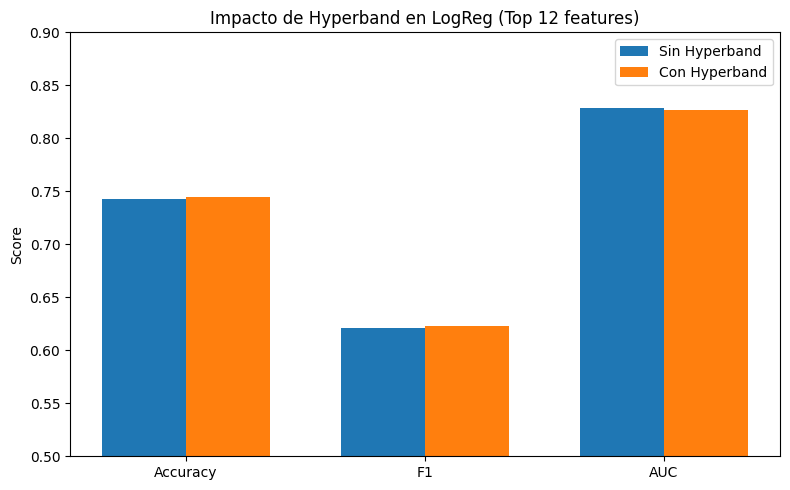

In [160]:
metrics = ["Accuracy", "F1", "AUC"]
base_vals = [res_top12_base[m] for m in metrics]
hb_vals   = [res_top12_hb[m]   for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, base_vals, width, label="Sin Hyperband")
plt.bar(x + width/2, hb_vals,   width, label="Con Hyperband")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0.5, 0.9)
plt.title("Impacto de Hyperband en LogReg (Top 12 features)")
plt.legend()
plt.tight_layout()
plt.show()


## 7. Experimentation with PCA:

In [161]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled  = scaler.transform(X_test_prep)


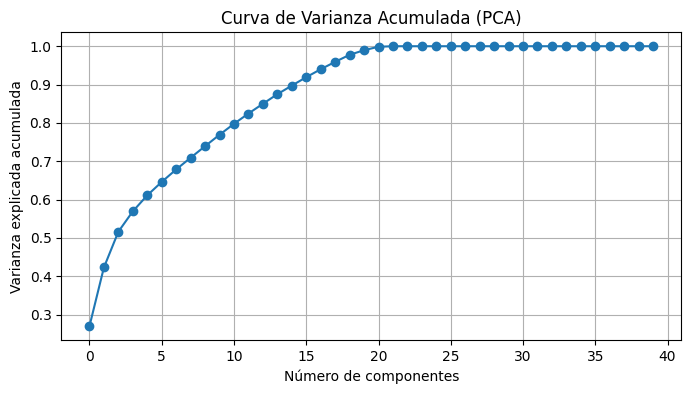

In [162]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca = PCA().fit(X_train_scaled)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Curva de Varianza Acumulada (PCA)")
plt.grid()
plt.show()


In [163]:
pca15 = PCA(n_components=12)
X_train_pca = pca15.fit_transform(X_train_scaled)
X_test_pca  = pca15.transform(X_test_scaled)


In [164]:
lr_pca = LogisticRegression(**LR_PARAMS)

res_pca = evaluar_modelo(
    "LogReg + PCA (12 comp)",
    lr_pca,
    X_train_pca,
    y_train_smote,
    X_test_pca,
    y_test
)

res_pca


{'Model': 'LogReg + PCA (12 comp)',
 'Accuracy': 0.7359829666430092,
 'F1': np.float64(0.610062893081761),
 'AUC': np.float64(0.812893642305407),
 'Train_Time_sec': 0.0060291290283203125,
 'ConfusionMatrix': array([[746, 289],
        [ 83, 291]]),
 'y_pred': array([0, 0, 0, ..., 1, 1, 0], shape=(1409,))}

In [165]:
comparison_pca = pd.DataFrame([
    {
        "Model": res_full["Model"],
        "Accuracy": res_full["Accuracy"],
        "F1": res_full["F1"],
        "AUC": res_full["AUC"],
        "TrainTime": res_full["Train_Time_sec"]
    },
    {
        "Model": res_top12["Model"],
        "Accuracy": res_top12["Accuracy"],
        "F1": res_top12["F1"],
        "AUC": res_top12["AUC"],
        "TrainTime": res_top12["Train_Time_sec"]
    },
    {
        "Model": res_pca["Model"],
        "Accuracy": res_pca["Accuracy"],
        "F1": res_pca["F1"],
        "AUC": res_pca["AUC"],
        "TrainTime": res_pca["Train_Time_sec"]
    }
])

comparison_pca


,Model,Accuracy,F1,AUC,TrainTime
0,LogReg - Full (all features),0.742370,0.619098,0.830499,0.024403
1,LogReg - Top 12 features,0.743080,0.621339,0.829055,0.009583
2,LogReg + PCA (12 comp),0.735983,0.610063,0.812894,0.006029


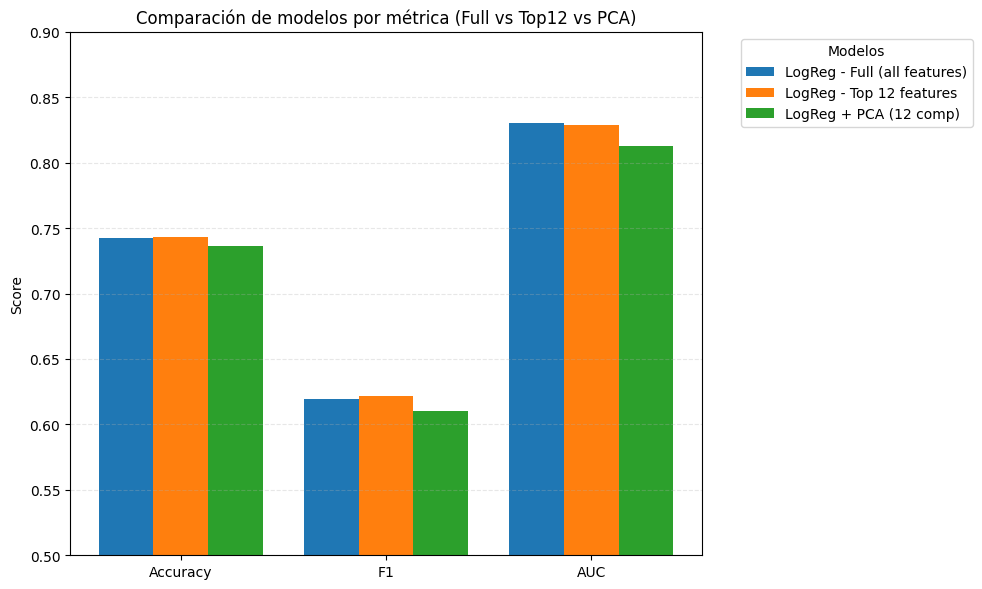

In [166]:

metrics = ["Accuracy", "F1", "AUC"]
x = np.arange(len(metrics))        # posiciones en el eje X (las métricas)
n_models = len(comparison_pca)     # número de modelos
width = 0.8 / n_models             # ancho de cada barra

plt.figure(figsize=(10, 6))

for i, (_, row) in enumerate(comparison_pca.iterrows()):
    scores = [row["Accuracy"], row["F1"], row["AUC"]]
    offset = (i - n_models/2) * width + width/2
    plt.bar(x + offset, scores, width, label=row["Model"])

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0.5, 0.9)
plt.title("Comparación de modelos por métrica (Full vs Top12 vs PCA)")
plt.legend(title="Modelos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Experimentation with t-SNE:

In [167]:
best_lr_base = LogisticRegression(**LR_PARAMS)

res_full = evaluar_modelo(
    "LogReg + SMOTE (Full Features)",
    best_lr_base,
    X_train_smote,
    y_train_smote,
    X_test_prep,
    y_test
)


In [168]:
top12 = df_imp_smote.head(12)["Feature"].tolist()

X_train_top12 = X_train_smote[top12]
X_test_top12  = X_test_prep[top12]

lr_top12 = LogisticRegression(**LR_PARAMS)

res_top12 = evaluar_modelo(
    "LogReg + SMOTE (Top 12 features)",
    lr_top12,
    X_train_top12,
    y_train_smote,
    X_test_top12,
    y_test
)


In [169]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled  = scaler.transform(X_test_prep)

pca = PCA(n_components=20)   # Ajusta según tu varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

lr_pca = LogisticRegression(**LR_PARAMS)

res_pca = evaluar_modelo(
    "LogReg + SMOTE + PCA",
    lr_pca,
    X_train_pca,
    y_train_smote,
    X_test_pca,
    y_test
)


In [170]:
from sklearn.manifold import TSNE
import numpy as np

# Usamos datos escalados (ya hechos arriba)
X_all_scaled = np.vstack([X_train_scaled, X_test_scaled])

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42
)

X_all_tsne = tsne.fit_transform(X_all_scaled)

n_train = X_train_scaled.shape[0]
X_train_tsne = X_all_tsne[:n_train]
X_test_tsne  = X_all_tsne[n_train:]
best_lr_tsne = LogisticRegression(**LR_PARAMS)

res_tsne = evaluar_modelo(
    "LogReg + SMOTE + t-SNE",
    best_lr_tsne,
    X_train_tsne,
    y_train_smote,
    X_test_tsne,
    y_test
)


In [171]:
comparison_final = pd.DataFrame([
    {
        "Model": res_full["Model"],
        "Accuracy": res_full["Accuracy"],
        "F1": res_full["F1"],
        "AUC": res_full["AUC"],
        "TrainTime": res_full["Train_Time_sec"]
    },
    {
        "Model": res_top12["Model"],
        "Accuracy": res_top12["Accuracy"],
        "F1": res_top12["F1"],
        "AUC": res_top12["AUC"],
        "TrainTime": res_top12["Train_Time_sec"]
    },
    {
        "Model": res_pca["Model"],
        "Accuracy": res_pca["Accuracy"],
        "F1": res_pca["F1"],
        "AUC": res_pca["AUC"],
        "TrainTime": res_pca["Train_Time_sec"]
    },
    {
        "Model": res_tsne["Model"],
        "Accuracy": res_tsne["Accuracy"],
        "F1": res_tsne["F1"],
        "AUC": res_tsne["AUC"],
        "TrainTime": res_tsne["Train_Time_sec"]
    }
])

comparison_final


,Model,Accuracy,F1,AUC,TrainTime
0,LogReg + SMOTE (Full Features),0.742370,0.619098,0.830499,0.026240
1,LogReg + SMOTE (Top 12 features),0.743080,0.621339,0.829055,0.010856
2,LogReg + SMOTE + PCA,0.733144,0.611570,0.821253,0.008636
3,LogReg + SMOTE + t-SNE,0.696238,0.548523,0.755251,0.005549


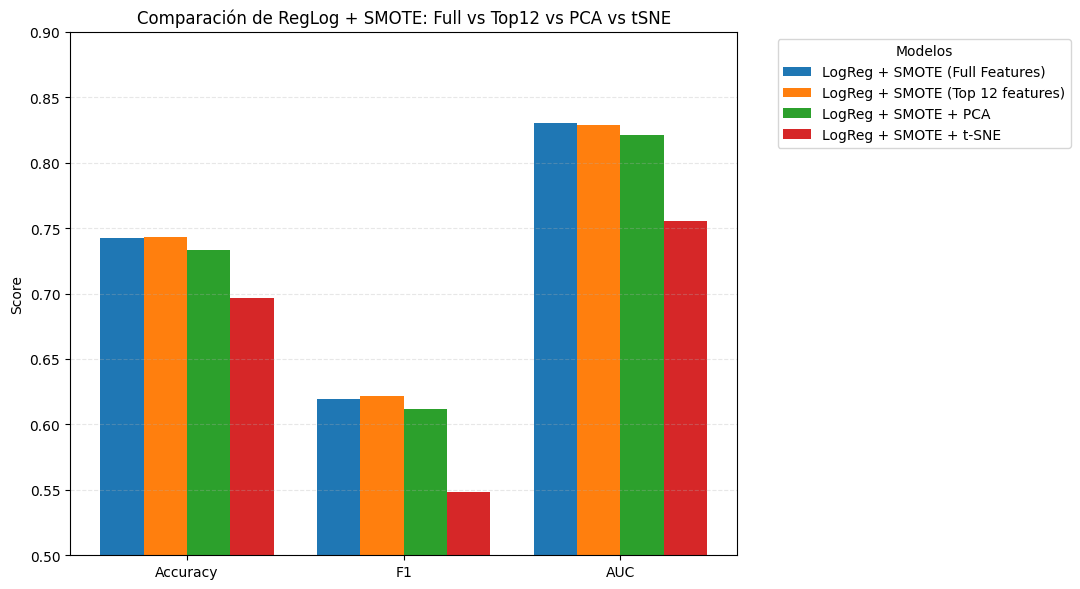

In [172]:
metrics = ["Accuracy", "F1", "AUC"]
x = np.arange(len(metrics))
n_models = len(comparison_final)
width = 0.8 / n_models

plt.figure(figsize=(11, 6))

for i, (_, row) in enumerate(comparison_final.iterrows()):
    vals = [row[m] for m in metrics]
    offset = (i - n_models/2)*width + width/2
    plt.bar(x + offset, vals, width, label=row["Model"])

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0.5, 0.9)
plt.title("Comparación de RegLog + SMOTE: Full vs Top12 vs PCA vs tSNE")
plt.legend(title="Modelos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Después de probar todas las variantes del modelo de Regresión Logística con SMOTE, queda claro que trabajar con las 12 variables más importantes es la opción más equilibrada. Este modelo mantiene prácticamente el mismo nivel de precisión y capacidad de discriminación que la versión con todas las variables, pero con un procesamiento más limpio, menos ruido y tiempos de entrenamiento más bajos. En pocas palabras: hace lo mismo, pero mejor optimizado.

Cuando aplicamos PCA, el desempeño sigue siendo aceptable, pero se nota una ligera pérdida de calidad porque este método proyecta la información a componentes que ya no representan variables reales. Es útil si queremos acelerar el entrenamiento, pero sacrifica algo de interpretabilidad y un poco de precisión.

Por otro lado, t-SNE confirmó lo que suele pasar en la práctica: sirve para visualizar datos y entender estructuras, pero no para entrenar modelos supervisados. El rendimiento cayó en todas las métricas, así que no es una buena alternativa para este tipo de problema.

En general, la conclusión práctica es simple:
Regresión Logística + SMOTE + las 12 features más importantes ofrece la mejor combinación de rendimiento, eficiencia y claridad en el modelo, lo cual es ideal para un sistema de predicción de churn que necesita ser efectivo y fácil de interpretar.

In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# ============================
# 1) Unir TRAIN + VAL para entrenar el modelo final
# ============================
train_val = pd.concat([train_set, val_set], axis=0)

X_train_val, y_train_val = remove_labels(train_val, "Churn")
X_test, y_test = remove_labels(test_set, "Churn")  # ya lo tenías antes, lo reutilizamos

print("Tamaño train+val:", X_train_val.shape)
print("Tamaño test:", X_test.shape)

# ============================
# 2) Ajustar el PREPROCESADOR final
# ============================
prep_final = DataFramePreparer()
prep_final.fit(X_train_val)

X_train_val_prep = prep_final.transform(X_train_val)
X_test_prep = prep_final.transform(X_test)

print("Shape X_train_val_prep:", X_train_val_prep.shape)
print("Shape X_test_prep:", X_test_prep.shape)

# ============================
# 3) Entrenar el MODELO final (Regresión Logística)
# ============================
best_lr_final = LogisticRegression(**LR_PARAMS)
best_lr_final.fit(X_train_val_prep, y_train_val)

# ============================
# 4) Evaluación final en TEST (solo para verificar)
# ============================
y_test_pred = best_lr_final.predict(X_test_prep)
y_test_proba = best_lr_final.predict_proba(X_test_prep)[:, 1]

print("== CLASIFICATION REPORT (TEST) ==")
print(classification_report(y_test, y_test_pred))

auc_test = roc_auc_score(y_test, y_test_proba)
print(f"AUC en test: {auc_test:.4f}")


Tamaño train+val: (5634, 19)
Tamaño test: (1409, 19)
Shape X_train_val_prep: (5634, 40)
Shape X_test_prep: (1409, 40)
== CLASIFICATION REPORT (TEST) ==
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

AUC en test: 0.8315


In [174]:
# ============================
# 5) Guardar pipeline + modelo para la app de Streamlit
# ============================

joblib.dump(prep_final, "pipeline.pkl")
joblib.dump(best_lr_final, "model.pkl")

print("✅ Archivos guardados:")
print(" - pipeline.pkl")
print(" - model.pkl")


✅ Archivos guardados:
 - pipeline.pkl
 - model.pkl


In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# 1) Unimos train + val para entrenar el modelo final
train_val = pd.concat([train_set, val_set], axis=0)

X_train_val, y_train_val = remove_labels(train_val, "Churn")
X_test, y_test = remove_labels(test_set, "Churn")

print("Tamaño train+val:", X_train_val.shape)
print("Tamaño test:", X_test.shape)

# 2) Definimos el Pipeline completo:
#    - primer paso: DataFramePreparer (todas las transformaciones)
#    - segundo paso: clasificador (Regresión Logística)
full_pipeline = Pipeline([
    ("prep", DataFramePreparer()),
    ("clf", LogisticRegression(**LR_PARAMS))
])

# 3) Entrenamos el pipeline completo
full_pipeline.fit(X_train_val, y_train_val)

# 4) Evaluamos en test (solo para ver cómo va)
y_test_pred = full_pipeline.predict(X_test)
y_test_proba = full_pipeline.predict_proba(X_test)[:, 1]

print("== CLASIFICATION REPORT (TEST) ==")
print(classification_report(y_test, y_test_pred))

auc_test = roc_auc_score(y_test, y_test_proba)
print(f"AUC en test: {auc_test:.4f}")


Tamaño train+val: (5634, 19)
Tamaño test: (1409, 19)
== CLASIFICATION REPORT (TEST) ==
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

AUC en test: 0.8315


In [176]:
joblib.dump(full_pipeline, "pipeline.pkl")
print("✅ Pipeline completo guardado en 'pipeline.pkl'")


✅ Pipeline completo guardado en 'pipeline.pkl'


In [177]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd

# -----------------------------------------
# 1) Pipeline numérico
# -----------------------------------------
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# -----------------------------------------
# 2) CustomOneHotEncoder
# -----------------------------------------
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        try:
            self._oh = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        except TypeError:
            self._oh = OneHotEncoder(sparse=False, handle_unknown="ignore")
        self._columns = []

    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object']).copy()
        if X_cat.shape[1] == 0:
            self._columns = []
            self._oh.fit(pd.DataFrame(index=X.index))
            return self
        self._oh.fit(X_cat)
        self._columns = self._oh.get_feature_names_out(X_cat.columns)
        return self

    def transform(self, X, y=None):
        X_cat = X.select_dtypes(include=['object']).copy()
        if X_cat.shape[1] == 0:
            return pd.DataFrame(index=X.index)
        X_cat_oh = self._oh.transform(X_cat)
        return pd.DataFrame(X_cat_oh, columns=self._columns, index=X.index)

# -----------------------------------------
# 3) CustomPreImputer
# -----------------------------------------
class CustomPreImputer(BaseEstimator, TransformerMixin):
    """
    - Imputa TODAS las columnas categóricas (dtype 'object') con la moda.
    - Para columnas categóricas con EXACTAMENTE 2 valores distintos,
      las convierte a 0 y 1.
    - El resto de categóricas se dejan como texto para OneHotEncoder.
    """

    def __init__(self):
        self.cat_modes_ = {}       # moda de cada columna categórica
        self.binary_mappings_ = {} # dict: col -> {categoria: 0/1}

    def fit(self, X, y=None):
        X_df = X.copy()

        # 1) Identificar columnas categóricas
        cat_cols = X_df.select_dtypes(include=["object"]).columns

        for col in cat_cols:
            # Moda
            mode_col = X_df[col].dropna().mode()
            if len(mode_col) > 0:
                self.cat_modes_[col] = mode_col.iloc[0]

            # Serie imputada temporalmente para contar categorías
            temp = X_df[col].fillna(self.cat_modes_[col]) if col in self.cat_modes_ else X_df[col]
            uniques = list(pd.Series(temp).unique())

            # 2) Si la columna tiene EXACTAMENTE 2 categorías, la marcamos como binaria
            if len(uniques) == 2:
                # Caso especial: Yes/No → fijamos explícitamente 0/1
                if set(uniques) == {"Yes", "No"}:
                    mapping = {"No": 0, "Yes": 1}
                else:
                    # cualquier otro binario (Male/Female, etc.)
                    mapping = {uniques[0]: 0, uniques[1]: 1}
                self.binary_mappings_[col] = mapping

        return self

    def transform(self, X, y=None):
        X_df = X.copy()

        # 1) Imputar categóricas con su moda
        for col, mode_val in self.cat_modes_.items():
            if col in X_df.columns:
                X_df[col] = X_df[col].fillna(mode_val)

        # 2) Mapear columnas binarias a 0/1
        for col, mapping in self.binary_mappings_.items():
            if col in X_df.columns:
                X_df[col] = X_df[col].map(mapping).astype("Int64")

        return X_df

# -----------------------------------------
# 4) DataFramePreparer
# -----------------------------------------
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._pre_imputer = CustomPreImputer()   # para categóricas
        self._full_pipeline = None
        self._columns = None
        self.input_features_ = None

    def fit(self, X, y=None):
        # 0) Pre-imputación global
        X1 = self._pre_imputer.fit_transform(X)
        self.input_features_ = list(X1.columns)

        # 1) Detectar numéricas y categóricas DESPUÉS de la pre-imputación
        num_attribs = list(X1.select_dtypes(exclude=['object']).columns)
        cat_attribs = list(X1.select_dtypes(include=['object']).columns)

        # 2) ColumnTransformer con num_pipeline y OneHot
        self._full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X1)

        # 3) Guardar nombres de columnas de salida
        out_cols = []
        out_cols.extend(num_attribs)
        cat_encoder = self._full_pipeline.named_transformers_["cat"]
        if hasattr(cat_encoder, "_columns") and len(cat_encoder._columns) > 0:
            out_cols.extend(list(cat_encoder._columns))
        self._columns = out_cols
        return self

    def transform(self, X, y=None):
        X1 = self._pre_imputer.transform(X)
        X_prep = self._full_pipeline.transform(X1)
        return pd.DataFrame(X_prep, columns=self._columns, index=X.index)


In [178]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# 1) Separar X e y
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"No": 0, "Yes": 1})   # importante: binarizar

# 2) Train / test (si ya tienes train/val/test, usa eso)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



# 4) Pipeline completo: preprocesamiento + modelo
full_pipeline = Pipeline([
    ("prep", DataFramePreparer()),
    ("clf", LogisticRegression(**LR_PARAMS))
])

# 5) Entrenar TODO con una sola llamada
full_pipeline.fit(X_train, y_train)

# 6) Evaluar
y_pred = full_pipeline.predict(X_test)
y_proba = full_pipeline.predict_proba(X_test)[:, 1]

print("== CLASSIFICATION REPORT ==")
print(classification_report(y_test, y_pred))

print("AUC:", roc_auc_score(y_test, y_proba))


== CLASSIFICATION REPORT ==
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

AUC: 0.8414348084424811


In [179]:
joblib.dump(full_pipeline, "pipeline.pkl")
print("✅ Pipeline completo guardado en 'pipeline.pkl'")


✅ Pipeline completo guardado en 'pipeline.pkl'


In [180]:
print(full_pipeline.steps)


[('prep', DataFramePreparer()), ('clf', LogisticRegression(max_iter=1000, random_state=42))]


In [181]:
# Suponiendo que ya hiciste:
# full_pipeline.fit(X_train, y_train)

prep = full_pipeline.named_steps["prep"]

# Esto es el ColumnTransformer interno
print(prep._full_pipeline)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'tenure', 'PhoneService',
                                  'PaperlessBilling', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('cat', CustomOneHotEncoder(),
                                 ['MultipleLines', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies', 'Contract',
                                  'PaymentMethod'])])


In [182]:
from sklearn import set_config
set_config(display='diagram')
full_pipeline          # (en la última línea de la celda)

# y para ver la parte de preprocesamiento:
prep = full_pipeline.named_steps["prep"]
print(prep._full_pipeline)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'tenure', 'PhoneService',
                                  'PaperlessBilling', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('cat', CustomOneHotEncoder(),
                                 ['MultipleLines', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies', 'Contract',
                                  'PaymentMethod'])])


In [183]:
%pip install preprocessors

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement preprocessors (from versions: none)
ERROR: No matching distribution found for preprocessors


In [184]:
from preprocessors import DataFramePreparer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import joblib
import pandas as pd

# TOP 12 columnas originales necesarias
FEATURES_12_ORIG = [
    "TotalCharges",
    "tenure",
    "MonthlyCharges",
    "Contract",
    "TechSupport",
    "OnlineSecurity",
    "PaymentMethod",
    "PaperlessBilling",
    "gender",
    "InternetService",
    "Dependents"
]

# =====================
# 1) Preparar dataset
# =====================
df2 = df.copy()
if "customerID" in df2.columns:
    df2 = df2.drop("customerID", axis=1)

X = df2[FEATURES_12_ORIG].copy()
y = df2["Churn"].map({"No": 0, "Yes": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# =====================
# 2) Definir modelo LR
# =====================
LR_PARAMS = {
    "solver": "liblinear",
    "C": 1.0,
    "class_weight": None,
    "max_iter": 1000,
    "random_state": 42
}

# =====================
# 3) Pipeline completo
# =====================
pipeline_smote_top12 = ImbPipeline(steps=[
    ("prep", DataFramePreparer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(**LR_PARAMS))
])

# =====================
# 4) Entrenamiento
# =====================
pipeline_smote_top12.fit(X_train, y_train)

# =====================
# 5) Evaluación
# =====================
y_pred = pipeline_smote_top12.predict(X_test)
y_proba = pipeline_smote_top12.predict_proba(X_test)[:, 1]

print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# =====================
# 6) Guardar modelo final
# =====================
joblib.dump(pipeline_smote_top12, "pipeline_smote_top12.pkl")
print("✅ Pipeline guardado como pipeline_smote_top12.pkl")


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.82      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

AUC: 0.8368286445012788
✅ Pipeline guardado como pipeline_smote_top12.pkl


In [186]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from preprocessors import DataFramePreparer  # usamos el de preprocessors.py

# ================== 1) Cargar dataset ==================
df = pd.read_csv("Telco-Customer-Churn.csv")

# Asegurar que TotalCharges sea numérico (a veces viene con espacios)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Quitamos ID
if "customerID" in df.columns:
    df = df.drop("customerID", axis=1)

# ================== 2) Definir X, y ==================
# columnas crudas que corresponden a tu top-12 post-OHE
FEATURES_TOP_RAW = [
    "TotalCharges",
    "tenure",
    "MonthlyCharges",
    "Contract",
    "TechSupport",
    "OnlineSecurity",
    "PaymentMethod",
    "PaperlessBilling",
    "gender",
    "InternetService",
    "Dependents",
]

X = df[FEATURES_TOP_RAW].copy()
y = df["Churn"].map({"No": 0, "Yes": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ================== 3) Definir pipeline: prep + SMOTE + LR ==================
LR_PARAMS = {
    "solver": "liblinear",
    "C": 1.0,
    "class_weight": None,   # con SMOTE normalmente no usamos 'balanced'
    "max_iter": 1000,
    "random_state": 42
}

pipeline_telco_top_smote = ImbPipeline(steps=[
    ("prep", DataFramePreparer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(**LR_PARAMS))
])

# ================== 4) Entrenar ==================
pipeline_telco_top_smote.fit(X_train, y_train)

# ================== 5) Evaluar en test ==================
y_pred = pipeline_telco_top_smote.predict(X_test)
y_proba = pipeline_telco_top_smote.predict_proba(X_test)[:, 1]

print("== CLASSIFICATION REPORT (TEST) ==")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# ================== 6) Guardar pipeline ==================
joblib.dump(pipeline_telco_top_smote, "pipeline_telco_top_smote.pkl")
print("✅ Guardado en 'pipeline_telco_top_smote.pkl'")


== CLASSIFICATION REPORT (TEST) ==
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.82      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

AUC: 0.8368286445012788
✅ Guardado en 'pipeline_telco_top_smote.pkl'


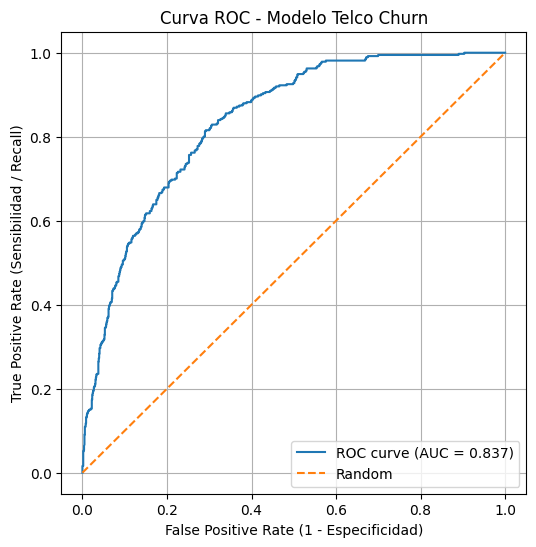

In [187]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# y_test: etiquetas reales (0/1)
# y_proba: probabilidades de la clase 1 (churn)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad / Recall)")
plt.title("Curva ROC - Modelo Telco Churn")
plt.legend()
plt.grid(True)
plt.show()


In [188]:
for thr, fp, tp in zip(thresholds[::50], fpr[::50], tpr[::50]):
    print(f"thr={thr:.2f} -> FPR={fp:.2f}, TPR={tp:.2f}")


thr=inf -> FPR=0.00, TPR=0.00
thr=0.84 -> FPR=0.03, TPR=0.23
thr=0.79 -> FPR=0.07, TPR=0.41
thr=0.73 -> FPR=0.11, TPR=0.54
thr=0.67 -> FPR=0.17, TPR=0.64
thr=0.53 -> FPR=0.27, TPR=0.77
thr=0.42 -> FPR=0.36, TPR=0.86
thr=0.25 -> FPR=0.50, TPR=0.93


In [189]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from preprocessors import DataFramePreparer  # tu pipeline de preprocesado


In [191]:
# Carga dataset Telco
df = pd.read_csv("Telco-Customer-Churn.csv")

# Limpieza básica
if "customerID" in df.columns:
    df = df.drop("customerID", axis=1)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

TARGET = "Churn"
TARGET_MAP = {"No": 0, "Yes": 1}

# Columnas de entrada (todas menos el target)
FEATURES_FULL = [c for c in df.columns if c != TARGET]

# Top features en CRUDO (las equivalentes a tu top-12 post-OHE)
FEATURES_TOP_RAW = [
    "TotalCharges",
    "tenure",
    "MonthlyCharges",
    "Contract",
    "TechSupport",
    "OnlineSecurity",
    "PaymentMethod",
    "PaperlessBilling",
    "gender",
    "InternetService",
    "Dependents",
]

# Filtrar filas completas para estas columnas
df_full = df.dropna(subset=[TARGET] + FEATURES_FULL).copy()
df_top  = df.dropna(subset=[TARGET] + FEATURES_TOP_RAW).copy()

X_full = df_full[FEATURES_FULL]
y_full = df_full[TARGET].map(TARGET_MAP).astype(int)

X_top = df_top[FEATURES_TOP_RAW]
y_top = df_top[TARGET].map(TARGET_MAP).astype(int)

# Usamos la misma partición train/test para todos los modelos
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y_top, test_size=0.2, random_state=42, stratify=y_top
)


In [192]:
def evaluar_modelo(nombre, model, X_train, y_train, X_test, y_test):
    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_proba_test  = model.predict_proba(X_test)[:, 1]

    y_pred_train = (y_proba_train >= 0.5).astype(int)
    y_pred_test  = (y_proba_test  >= 0.5).astype(int)

    metrics = {}

    metrics["acc_train"] = accuracy_score(y_train, y_pred_train)
    metrics["acc_test"]  = accuracy_score(y_test,  y_pred_test)

    metrics["f1_train"] = f1_score(y_train, y_pred_train)
    metrics["f1_test"]  = f1_score(y_test,  y_pred_test)

    metrics["auc_train"] = roc_auc_score(y_train, y_proba_train)
    metrics["auc_test"]  = roc_auc_score(y_test,  y_proba_test)

    print(f"\n===== {nombre} =====")
    print(f"Accuracy  (train/test): {metrics['acc_train']:.3f} / {metrics['acc_test']:.3f}")
    print(f"F1        (train/test): {metrics['f1_train']:.3f} / {metrics['f1_test']:.3f}")
    print(f"AUC       (train/test): {metrics['auc_train']:.3f} / {metrics['auc_test']:.3f}")
    print("\nReporte de clasificación (test):")
    print(classification_report(y_test, y_pred_test))

    return metrics


In [193]:
LR_PARAMS = {
    "solver": "liblinear",
    "C": 1.0,
    "class_weight": None,  # con SMOTE no usamos 'balanced'
    "max_iter": 1000,
    "random_state": 42
}

# FULL FEATURES
pipe_logreg_full = ImbPipeline(steps=[
    ("prep", DataFramePreparer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(**LR_PARAMS))
])

pipe_logreg_full.fit(X_train_full, y_train_full)

_ = evaluar_modelo(
    "LogReg + SMOTE (FULL FEATURES)",
    pipe_logreg_full,
    X_train_full,
    y_train_full,
    X_test_full,
    y_test_full
)

joblib.dump(pipe_logreg_full, "logreg_full.pkl")
print("✅ Guardado logreg_full.pkl")



===== LogReg + SMOTE (FULL FEATURES) =====
Accuracy  (train/test): 0.762 / 0.731
F1        (train/test): 0.640 / 0.608
AUC       (train/test): 0.850 / 0.834

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407

✅ Guardado logreg_full.pkl


In [194]:
# TOP FEATURES (crudas)
pipe_logreg_top = ImbPipeline(steps=[
    ("prep", DataFramePreparer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(**LR_PARAMS))
])

pipe_logreg_top.fit(X_train_top, y_train_top)

_ = evaluar_modelo(
    "LogReg + SMOTE (TOP FEATURES)",
    pipe_logreg_top,
    X_train_top,
    y_train_top,
    X_test_top,
    y_test_top
)

joblib.dump(pipe_logreg_top, "logreg_top.pkl")
print("✅ Guardado logreg_top.pkl")



===== LogReg + SMOTE (TOP FEATURES) =====
Accuracy  (train/test): 0.753 / 0.731
F1        (train/test): 0.632 / 0.609
AUC       (train/test): 0.846 / 0.833

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407

✅ Guardado logreg_top.pkl


In [195]:
RF_PARAMS = {
    "n_estimators": 300,
    "max_depth": None,
    "min_samples_split": 10,
    "min_samples_leaf": 5,
    "random_state": 42,
    "n_jobs": -1
}

# FULL FEATURES
pipe_rf_full = ImbPipeline(steps=[
    ("prep", DataFramePreparer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(**RF_PARAMS))
])

pipe_rf_full.fit(X_train_full, y_train_full)

_ = evaluar_modelo(
    "RandomForest + SMOTE (FULL FEATURES)",
    pipe_rf_full,
    X_train_full,
    y_train_full,
    X_test_full,
    y_test_full
)

joblib.dump(pipe_rf_full, "rf_full.pkl")
print("✅ Guardado rf_full.pkl")



===== RandomForest + SMOTE (FULL FEATURES) =====
Accuracy  (train/test): 0.861 / 0.777
F1        (train/test): 0.760 / 0.624
AUC       (train/test): 0.937 / 0.828

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1033
           1       0.57      0.70      0.62       374

    accuracy                           0.78      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.80      0.78      0.78      1407

✅ Guardado rf_full.pkl


In [196]:
# TOP FEATURES
pipe_rf_top = ImbPipeline(steps=[
    ("prep", DataFramePreparer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(**RF_PARAMS))
])

pipe_rf_top.fit(X_train_top, y_train_top)

_ = evaluar_modelo(
    "RandomForest + SMOTE (TOP FEATURES)",
    pipe_rf_top,
    X_train_top,
    y_train_top,
    X_test_top,
    y_test_top
)

joblib.dump(pipe_rf_top, "rf_top.pkl")
print("✅ Guardado rf_top.pkl")



===== RandomForest + SMOTE (TOP FEATURES) =====
Accuracy  (train/test): 0.838 / 0.758
F1        (train/test): 0.739 / 0.622
AUC       (train/test): 0.929 / 0.828

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1033
           1       0.53      0.75      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.76      0.77      1407

✅ Guardado rf_top.pkl


In [197]:
GB_PARAMS = {
    "n_estimators": 200,
    "learning_rate": 0.05,
    "max_depth": 3,
    "random_state": 42
}

# FULL FEATURES
from sklearn.pipeline import Pipeline

pipe_gb_full = Pipeline(steps=[
    ("prep", DataFramePreparer()),
    ("clf", GradientBoostingClassifier(**GB_PARAMS))
])

pipe_gb_full.fit(X_train_full, y_train_full)

_ = evaluar_modelo(
    "GradientBoosting (FULL FEATURES)",
    pipe_gb_full,
    X_train_full,
    y_train_full,
    X_test_full,
    y_test_full
)

joblib.dump(pipe_gb_full, "model3_full.pkl")
print("✅ Guardado model3_full.pkl")



===== GradientBoosting (FULL FEATURES) =====
Accuracy  (train/test): 0.830 / 0.792
F1        (train/test): 0.646 / 0.576
AUC       (train/test): 0.884 / 0.839

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407

✅ Guardado model3_full.pkl


In [198]:
# TOP FEATURES
pipe_gb_top = Pipeline(steps=[
    ("prep", DataFramePreparer()),
    ("clf", GradientBoostingClassifier(**GB_PARAMS))
])

pipe_gb_top.fit(X_train_top, y_train_top)

_ = evaluar_modelo(
    "GradientBoosting (TOP FEATURES)",
    pipe_gb_top,
    X_train_top,
    y_train_top,
    X_test_top,
    y_test_top
)

joblib.dump(pipe_gb_top, "model3_top.pkl")
print("✅ Guardado model3_top.pkl")



===== GradientBoosting (TOP FEATURES) =====
Accuracy  (train/test): 0.827 / 0.792
F1        (train/test): 0.639 / 0.580
AUC       (train/test): 0.882 / 0.836

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407

✅ Guardado model3_top.pkl
